# Exercise 3

In this assignment, you will find numerical solutions to the diffusion equation. In particular, you will use an implicit method, and consider problems with both Dirichlet and Neumann boundary conditions.

**Remember**
   * You are expected to use numpy and scipy libraries where appropriate.  
   * You should run each cell in order from the top of the notebook; there is no need to repeat code between cells
   * Use the "refresh kernel" button to reset everything and start again
   * Make sure your notebook runs fully & without errors, from a fresh kernel, before submitting it

## Problem Overview

The 1D diffusion equation is :

$$\frac{\partial u}{\partial t} = k\frac{\partial^2 u}{\partial x^2}$$

You should discretize this equation onto $N_x$ space points, with separation $\Delta x = h$, and into timesteps $\Delta t = \tau$.  In the equations below, I use subscript $i$ as a space index, and superscript $n$ for time indices.

Having discretized the problem, you should use the _implicit_ finite difference equation, as discussed in lectures :

$$\frac{u_i^{n+1} - u_i^n}{\tau} = k \frac{u_{i+1}^{n+1} - 2u_i^{n+1} + u_{i-1}^{n+1}}{h^2}$$

This can be written in matrix form $u^n = M u^{n+1}$ using :

$$u_i^n = - \alpha u_{i-1}^{n+1} + (1 + 2\alpha) u_i^{n+1} - \alpha u_{i+1}^{n+1}$$

where $\alpha = \frac{k \tau}{h^2}$.

In the problems below, you are asked to solve the diffusion equation in the context of the heat equation. Here, $k$ is the thermal diffusivity, given by $k = \frac{\lambda}{\rho C}$, where $\lambda$ is the thermal conductivity, $\rho$ is the density, and $C$ is the specific heat capacity. The questions below concern an iron poker of length 50cm.  You may take the thermal conductivity of iron to be a constant 59 W/m/K, its specific heat as 450 J/kg/K, and its density as 7,900 kg/m3.  You can ignore heat loss along the length of the poker.


## Part 1 - FiniteDIfference Boundary Conditions

The poker is initially in equilibrium, at room temperature of 20 C. At time $t = 0$, one end is thrust into a furnace at 1000 C and the other end is held in an ice bath at 0 C. Your task is to calculate the temperature distribution along the poker as a function of time.

The fact that the ends of the rod are held at fixed temperatures of 0 C and 1000 C corresponds to a FiniteDIfference boundary condition.  These can be included in the implicit method as follows.

The implicit finite difference equation, above, will allow us to calculate the unknown 'internal' nodes, ie. $0 < i < (N_x-1)$.  However, the boundary nodes, $i=0, N_x$, must have fixed values $d_0, d_N$.  To fix the boundaries, we take the matrix M to be of size $(N_x-2) \times (N_x-2)$, and adding a vector term :

$$u^n = Mu^{n+1} + b$$

For $N_x = 7$ (for example), this gives :

$$
M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+2\alpha & \\
\end{pmatrix}
$$

$$
b = \begin{pmatrix}
-\alpha d_0 \\
0 \\
0 \\
0 \\
-\alpha d_N \\
\end{pmatrix}
$$

You can show this gives the required finite equation for $i=1, (N-1)$, eg. :

$$u^n_1 = - \alpha u^{n+1}_2 + (1 + 2\alpha)u^{n+1}_1 - \alpha d_0$$

First, write functions that will construct the matrix equation and boundary value term.

In [1]:
#--------------------------------------------------------------------
#Here we construct several key elements of the program such as classes as weel as the two functions that handle the boundary conditions and the main tri-diagonal   (this is done with sparse matrices to save memory and computational power - no need to compute all those zeroes!)
#--------------------------------------------------------------------
from scipy import sparse
import scipy
from scipy.sparse.linalg import spsolve
import numpy as np
import matplotlib.pyplot as plt
import warnings

class Metal:
    def __init__(self, llambda: float, rho: float, C: float, L: float):
        self.llambda = llambda # Thermal conductivity
        self.rho = rho #density
        self.C = C # Specific heat
        self.L = L  # Length of rod

    def thermaldiff(self):
        '''
        Returns our value k - thermaldiffusivity for given values of lambda, rho and C
        '''
        return self.llambda / (self.rho * self.C)
    
Iron = Metal(llambda = 59, rho = 7900, C = 450, L = 0.5)

print("Thermal Diffusivity of our Iron rod:",Iron.thermaldiff()) # testing that i get the right constant!

class FiniteDifference:
    def __init__(self, N: int, t, x, d_0: float, d_N: float, bc: str):
        self.N = N  #Dimension of matrix
        self.t = t  #temporal points
        self.x = x  #spatial points
        self.d_0 = d_0 #temperature at intial space point (x = 0.0)
        self.d_N = d_N  #temperature at final space point (x = 0.5)
        self.bc = bc #boundary condition statement

    def tau(self, t):
        """
        Our timestep, calculated simply by taking a difference of points, hence it depends on how many time points there are.
        """
        return t[1] - t[0]

    def h(self, x):
        """
        Our spatial-step, calculated simply by taking a difference of points, hence it depends on how many spatial points there are.
        """
        return x[1] - x[0]

    def alpha(self, Metal):
        '''
        Our constant term in the sparse matrices, simply takes a value of k from our Metal class, as well as the time/spatial steps and returns a value for alpha
        '''
        k = Metal.thermaldiff()
        return (k *  self.tau(self.t)) / (self.h(self.x))**2
    
    def tridiag(self, lower, main, upper):
        """
        Creates a tridiagonal matrices using the scipy.sparse library, more efficient that iterating over an entire matrices with zeros included. This way, we get 
        to skip calculations for all those zeros in favour of computational efficiency with no loss in accuracy.
        """
        N = self.N #system size
        M = sparse.diags([lower * np.ones(N-3), main * np.ones(N-2), upper * np.ones(N-3)], [-1, 0, 1], shape = ((N-2, N-2)), format = 'csr')# our sparse matrix
        return M

    def impmat(self, Metal):
        """
        A function for creating the sparse matrix for implicit scheme, we simply specify the values of the diagonals and pass that to our .tridiag() function to create
        the matrix.
        """
        a = self.alpha(Metal)
        lower = - a#lower diagonal
        main = (1 + 2 * a) #main diagonal
        upper = - a #upper diagonal
        A = self.tridiag(lower, main, upper)
        A[-1, -1] = 1+a if self.bc == 'neumann' else 1 + 2*a #if statement to handle the neuman BC case, as the matrix changes.
        return A

    def crankmat(self, Metal, matrix):
        """
        A function for creating the sparse matrix for crank-nicholson scheme, we simply specify 
        the values of the diagonals and pass that to our .tridiag() function to create
        the matrix. Crank-nicholson scheme requires two matrices - one for the updated u's and the old u's.
        """
        ### Matrix Equation for CN: mat1 * u_n1 = mat2 * u_n
        a = self.alpha(Metal)
        lower = - a / 2
        main = 1 + a 
        upper = -a / 2
        main2 = 1 - a
        mat1 = self.tridiag(lower, main, upper) #
        mat2 = self.tridiag(-lower, main2, -upper)
        if self.bc == 'neumann': #neumann entries in sparse matrix
            mat1[-1, -1] = 1+a/2
            mat2[-1, -1] = 1-a / 2
        if matrix == 'mat1':
            return mat1
        elif matrix =='mat2':
            return mat2



    def BoundaryCondition(self, Metal) -> np.ndarray:
        """
        Function to create the boundary condition term required for calculated the internal nodes of our grid. 
        """
        a = self.alpha(Metal); N = self.N
        if self.bc =='dirichlet':
            B = np.zeros(N-2)
            B[0] = -a * self.d_0
            B[-1] = -a * self.d_N
            return B
        elif self.bc == 'neumann':
            B = np.zeros(N-2)
            B[0] = -a * self.d_0
            return B
        
times = np.linspace (0, 8, 9) # just some test parameters, feel free to ignore.
points = np.linspace(0, 8, 5)
TestMetal = Metal(llambda = 1, rho = 1, C = 1, L = 0.5)
TestDirichlet = FiniteDifference(7, times, points, 1000, 0, 'dirichlet')


print("\n", "Our test value for alpha:", TestDirichlet.alpha(TestMetal))

print("\n", "Our Test Matrix with Dirichlet BC's:", "\n",TestDirichlet.impmat(TestMetal).toarray())

print("\n","Our Boundary Condition term for Dirichlet BC's :", TestDirichlet.BoundaryCondition(TestMetal))



# "All test results look correct from expected forms. Note i used .toarray() here to simply 
# show the matrices in a nicer form than how sparse matrices usually look, i do not use .toarray()
# in calculations as to save computational power and time - it's more efficient to not calculate all those zeros. "




Thermal Diffusivity of our Iron rod: 1.659634317862166e-05

 Our test value for alpha: 0.25

 Our Test Matrix with Dirichlet BC's: 
 [[ 1.5  -0.25  0.    0.    0.  ]
 [-0.25  1.5  -0.25  0.    0.  ]
 [ 0.   -0.25  1.5  -0.25  0.  ]
 [ 0.    0.   -0.25  1.5  -0.25]
 [ 0.    0.    0.   -0.25  1.5 ]]

 Our Boundary Condition term for Dirichlet BC's : [-250.    0.    0.    0.   -0.]


Now write a function which will transport the temperature distribution at time step $n$ to time step $n+1$. You will need to use an appropriate linear algebra routine.

In [2]:
#--------------------------------------------------------------------
# Now we go on to implement the implicit and crank-nicholson finite difference schemes to transport our temperature distribution along the rod to the next time 
# step using .spsolve
#--------------------------------------------------------------------
def transport(FiniteDifference, u, Metal, scheme:str):
    """
    Transports the temperature distribution at a time step n to time step n+1. I rearrange the matrix equation here. Takes a specified scheme, and uses the corresponding
    matrix equation 
    """
    a = FiniteDifference.alpha(Metal)
    if scheme == 'Implicit':
         #matrix equation for implicit: u_n = A * u_n1
         A = FiniteDifference.impmat(Metal)
         B = u - FiniteDifference.BoundaryCondition(Metal)
    elif scheme == 'Crank-Nicholson':
         #Matrix Equation for CN: A * u_n1 = mat2 * u_n
         A = FiniteDifference.crankmat(Metal, 'mat1')
         mat2 = FiniteDifference.crankmat(Metal, 'mat2')
         B = mat2 * u - FiniteDifference.BoundaryCondition(Metal)
     #not sure if using operations when passing variables here affects performance, but should be ok -> is okay, if statements allow code to be ignored. 
    u_n1 = spsolve(A, B) # sparse solver from scipy, both efficient and accurate
    return u_n1


Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using an appropriate plotting routine.

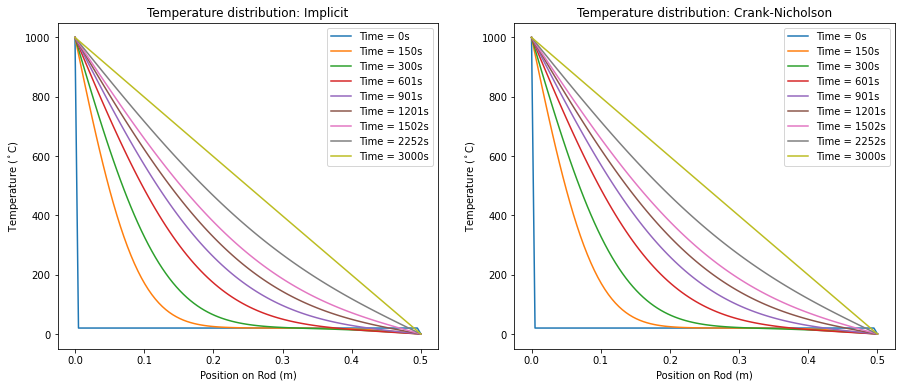

In [3]:
#--------------------------------------------------------------------
#Finally, we implement a simple loop to calculate the temperature distribution for all the time steps, and then plot using matplotlib.
# This cell may be a little bit dense.
#--------------------------------------------------------------------
def time_temp(FiniteDifference, T, scheme):
    """
    Our function for calculating the temperature distribution up to a specified timestep (T). Also handles which boundary conditions are applied, as how we update changes for 
    neumann
    """
    grid = np.full((T, FiniteDifference.N), 20.0) # our full grid for the rod, extremes are held at 1000C and 0C
    grid[:, 0] = FiniteDifference.d_0 # setting the start of the rod to be 1000C
    u = np.full(FiniteDifference.N-2, 20.00) # our known initial temperatures along the rod
    internal = grid[:, 1:FiniteDifference.N-1] # our internal nodes for the rod
    if FiniteDifference.bc == 'dirichlet':
        grid[:, -1] = FiniteDifference.d_N # setting the end of the rod to be held at 0C for the dirichlet BC's
        for k in range(1, T):
            internal[k, ] = transport(FiniteDifference, u, Iron, scheme) # calculate u_n1
            u[:] = internal[k, ] #update old u_n and then repeat
    elif FiniteDifference.bc == 'neumann':
        for k in range(1, T):
            internal[k, ] = transport(FiniteDifference, u, Iron, scheme)
            # internal[:, -1] = internal[:, -2]
            grid[:, -1] = grid[:, -2] # neumann requires the last two values in the temperature distribution to be held at the same temperature
            u[:] = internal[k, ] 
    return grid

Time = 3000
numpoints = 100
timepoints = 1000
ts = np.linspace(0, Time, timepoints)
# ts = np.arange(0, T, 100)
xs = np.linspace(0, Iron.L, numpoints)

Dirichlet = FiniteDifference(numpoints, ts, xs, 1000, 0, 'dirichlet')
# print(time_temp(Dirichlet, Time, 'Crank-Nicholson'))

# ---------------------------------------------------
# def timeplots(k:int, n:int, FiniteDifference, T, scheme): old plotting function
#     timelabel = "%.0f"%ts[k]
#     fig, axs = plt.subplots(1, 2, figsize=(16, 6))
#     axs[n].set_title(f"Temperature distribution: %s Scheme" % scheme)
#     axs[n].set_ylabel('Temperature ($^\circ$C)')
#     axs[n].set_xlabel('Position on Rod (m)')
#     axs[n].plot(xs, time_temp(FiniteDifference, T, scheme)[k,:], label = f'Time = {timelabel}s')
#     plt.legend()
# ---------------------------------------------------

def dirichletplots():
    '''
    Plotting function to show the two schemes side-by-side, takes a while to plot however :/
    '''
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].set_title("Temperature distribution: Implicit")
    axs[0].set_ylabel('Temperature ($^\circ$C)')
    axs[0].set_xlabel('Position on Rod (m)')

    axs[1].set_title("Temperature distribution: Crank-Nicholson")
    axs[1].set_ylabel('Temperature ($^\circ$C)')
    axs[1].set_xlabel('Position on Rod (m)')
    plots = [0, 50, 100, 200, 300, 400, 500, 750, -1]
    for k in plots:
        timelabel = "%.0f"%ts[k]
        axs[0].plot(xs, time_temp(Dirichlet, Time, 'Implicit')[k,:], label = f'Time = {timelabel}s')
        axs[1].plot(xs, time_temp(Dirichlet, Time, 'Crank-Nicholson')[k,:], label = f'Time = {timelabel}s')
    axs[0].legend()
    axs[1].legend()
    plt.show()
dirichletplots() #this function and the adjacent for the neumann plots tend to take a while. ~42s for this and ~+2mins for the neumann




## Part 2 - Neumann Boundary Conditions

Now we assume the far end of the poker from the furnace is no longer held at 0 C, but instead experiences no heat loss. Again your task is to find the tempeterature distribution as a function of time.

In this case, you will need to implement a Neumann boundary condition at the end of the poker, to ensure the derivative $\frac{\partial u}{\partial x}$ is zero. Since we are using finite differences, this is equivalent to ensuring the final two nodes have the same value.

The finite difference equation for node $i=(N-1)$ is :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + 2\alpha)u^{n+1}_{N-1} - \alpha u^{n+1}_{N}$$

To enforce the Neumann boundary condition we can substitute $u^{n+1}_{N} = u^{n+1}_{N-1}$, giving :

$$u^n_{N-1} = -\alpha u^{n+1}_{N-2} + (1 + \alpha)u^{n+1}_{N-1}$$

This results in a modified form of $M$, shown here for the example $N_x=7$, and the matrix ix $5\times5$ :  

$$
M = \begin{pmatrix}
1+2\alpha & -\alpha   &           &           &           & \\
-\alpha   & 1+2\alpha & -\alpha   &           &           & \\
          & -\alpha   & 1+2\alpha & -\alpha   &           & \\
          &           & -\alpha   & 1+2\alpha & -\alpha   & \\
          &           &           & -\alpha   & 1+\alpha & \\
\end{pmatrix}
$$

Note that you will also need to include a boundary term vector $b$, since the end of the poker in the furnace still requires a Dirichlet condition.

First write any new functions you need. You should be able to re-use some functions from Part 1.

In [4]:


TestNeumann = FiniteDifference(7, times, points, 1000, 20, 'neumann')
print("Our test matrix for the nuemann conditions (implicit scheme):", "\n", TestNeumann.impmat(TestMetal).toarray())
print("\n", "Our boundary condition vector for the nuemann conditions:", TestNeumann.BoundaryCondition(TestMetal))

NeuTime = 10000
temporalpoints = 1000
New_t = np.linspace(0, NeuTime, temporalpoints)
Neumann = FiniteDifference(numpoints, New_t, xs, 1000, 20, 'neumann')
# print(time_temp(Neumann, Newtimes, 'Implicit'))

Our test matrix for the nuemann conditions (implicit scheme): 
 [[ 1.5  -0.25  0.    0.    0.  ]
 [-0.25  1.5  -0.25  0.    0.  ]
 [ 0.   -0.25  1.5  -0.25  0.  ]
 [ 0.    0.   -0.25  1.5  -0.25]
 [ 0.    0.    0.   -0.25  1.25]]

 Our boundary condition vector for the nuemann conditions: [-250.    0.    0.    0.    0.]


Finally, use the functions above to calculate the temperature distribution as a function of time, and display this graphically using a sensible plotting function.

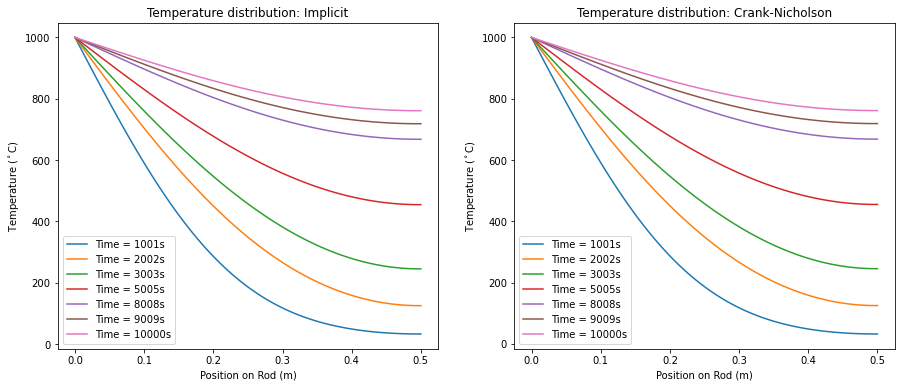

In [5]:
def neumannplots():
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))

    axs[0].set_title("Temperature distribution: Implicit")
    axs[0].set_ylabel('Temperature ($^\circ$C)')
    axs[0].set_xlabel('Position on Rod (m)')

    axs[1].set_title("Temperature distribution: Crank-Nicholson")
    axs[1].set_ylabel('Temperature ($^\circ$C)')
    axs[1].set_xlabel('Position on Rod (m)')
    plots = [100, 200, 300, 500, 800, 900, 999]
    for k in plots:
        timelabel = "%.0f"%New_t[k]
        axs[0].plot(xs, time_temp(Neumann, NeuTime, 'Implicit')[k,:], label = f'Time = {timelabel}s')
        axs[1].plot(xs, time_temp(Neumann, NeuTime, 'Crank-Nicholson')[k,:], label = f'Time = {timelabel}s')
    axs[0].legend()
    axs[1].legend()
    plt.show()

neumannplots() 

# not really sure why this takes so much longer than the dirichlet conditions, considering it's only a few more operations that 
# i thought would run at O(n) - maybe the plotting functions are ineffecient?


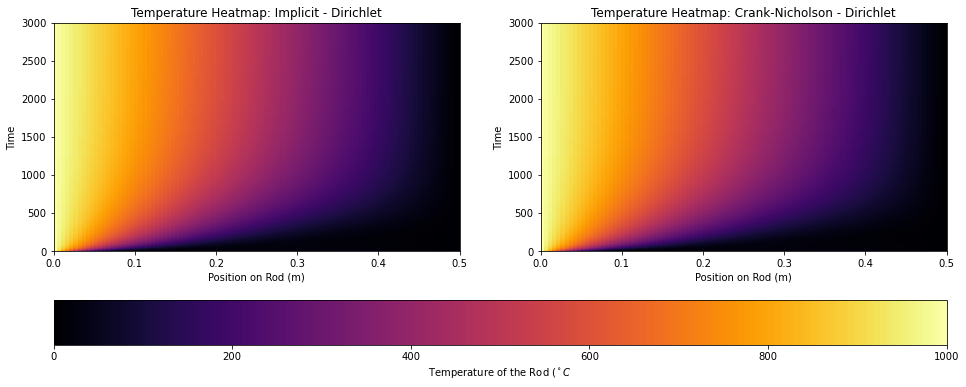

In [6]:
###Here i plot some heatmaps as an interesting way to show the temperature distribution

def dirichletheatmaps():
    """
    Plotting function for the heatmaps with dirichlet conditions
    """
    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    x_tick = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

    ax[0].set_title("Temperature Heatmap: Implicit - Dirichlet")
    ax[0].set_ylabel('Time')
    ax[0].set_xlabel('Position on Rod (m)')
    ax[0].set_xticklabels(x_tick)
    ax[1].set_xticklabels(x_tick)
    ax[1].set_title("Temperature Heatmap: Crank-Nicholson - Dirichlet")
    ax[1].set_ylabel('Time')
    ax[1].set_xlabel('Position on Rod (m)')
    c = ax[0].pcolor(time_temp(Dirichlet, Time, 'Implicit'), cmap = 'inferno')
    ax[1].pcolor(time_temp(Dirichlet, Time, 'Crank-Nicholson'), cmap = 'inferno')
    cbar = plt.colorbar(c, ax=ax, orientation = 'horizontal' )
    cbar.set_label("Temperature of the Rod ($^\circ C$")
    plt.show()

warnings.filterwarnings('ignore', category=UserWarning)
dirichletheatmaps()





Heatmaps are always fun to see, and in this one we can clearly see the temperature of the bar saturating as we go up in time


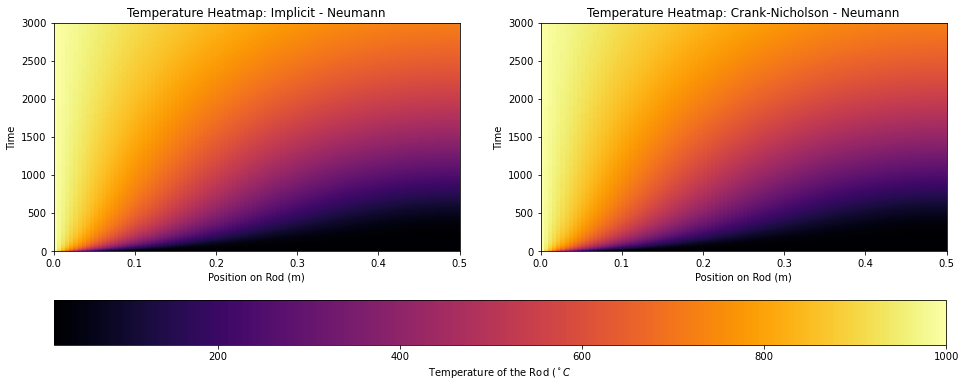

In [7]:


NeuHeatTime = 3000
temporalpoints = 1000
NewHeat_t = np.linspace(0, NeuHeatTime, temporalpoints)
NeumannHeat = FiniteDifference(numpoints, NewHeat_t, xs, 1000, 20, 'neumann')
def neumannheatmaps():
    """
    Plotting function for the heatmaps with neumann conditions.
    """

    fig, ax = plt.subplots(1, 2, figsize = (16, 6))
    x_tick = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ax[0].set_xticklabels(x_tick)
    ax[0].set_title("Temperature Heatmap: Implicit - Neumann")
    ax[0].set_ylabel('Time')
    ax[0].set_xlabel('Position on Rod (m)')
    
    # plt.gca().xaxis.set_major_formatter(FormatStrFormatter('{%.2f}'))
    ax[1].set_xticklabels(x_tick)
    ax[1].set_title("Temperature Heatmap: Crank-Nicholson - Neumann")
    ax[1].set_ylabel('Time')
    ax[1].set_xlabel('Position on Rod (m)')
    c = ax[0].pcolor(time_temp(NeumannHeat, NeuHeatTime, 'Implicit'), cmap = 'inferno')
    ax[1].pcolor(time_temp(NeumannHeat, NeuHeatTime, 'Crank-Nicholson'), cmap = 'inferno')

    cbar = plt.colorbar(c, ax=ax, orientation = 'horizontal' )
    cbar.set_label("Temperature of the Rod ($^\circ C$")
    plt.show()

print("Heatmaps are always fun to see, and in this one we can clearly see the temperature of the bar saturating as we go up in time")
warnings.filterwarnings('ignore', category=UserWarning) # can simply ignore this, it's just a label
neumannheatmaps()


# Part 3

In the Markdown cell below, describe how your code solves the problem set. State any equations used in the solution and how they were obtained. Include your reasons for any libraries you used, as well as any particular programming techniques. Explain your choice of any test cases. Finally, state any salient features of the results you obtained. You are not expected to write more than about 250-300 words.

${\large \underline{\text{The Matrix Equations}}}$

In the implicit scheme, the matrix equation is as follows;
\begin{equation}
u^n = M u^{n+1} + b
\end{equation}
Where $M$ is an $(N-2 \times N-2)$ tridiagonal matrix and $b$ is our boundary condition vector.
For the Crank-Nicholson Scheme;
\begin{equation}
M_1 u^{n+1} = M_2 u^{n} - b
\end{equation}
This is derived from the finite difference equations for the implicit and explicit schemes.

${\large \underline{\text{Solving the Systems}}}$

Solving the matrix equations is done using the scipy library, in particular the spsolve() function. Sparse matrices are pre-computed and used in the first code cell as we do not need to include all the zero entries in our matrices for the calculations to be correct. This is something we take advantage of, as spsolve() and sparse.diags() are two efficient functions for dealing with sparse matrices, in that the provide efficient computational means of solving the matrix equations with no loss of accuracy.
Once the sparse solver has been used, we simply iterate and update over all times to calculate the full temperature distribution along the rod.

${\large \underline{\text{The Results}}}$

The results are within good agreement with physical intuition, for both boundary conditions. The dirichlet plots show that our implementation demonstrates the correct behaviour as we would expect to see a linear relation ship in the temperature against position for a large enough time, which is what is shown. For the Neumann conditions, we can also see the correct behaviour as the rod simply continues to heat up as the end is no longer fixed to a cold reservoir. My implementation of the Crank-Nicholson method is more computationally expensive, taking almost double the time the implicit scheme takes to run. However it is known that the Crank-Nicholson method is accurate to second order in time and unconditionally stable, so the extra cost can be argued to be favourable over the implicit method, which is only accurate to first order.



---------------------------------------
||Feel free to ignore this cell if too long.|| 

${\large \underline{\text{Extensions}}}$

There are many extensions to be thought of here. To analyse computing time, we could have implemented both the sparse matrices and dense matrices and calculated the time it took to compute the temperature distribution for both to compare - we would expect to see sparse matrices be the faster method in this case. Also would analyse the times for implicit and crank-nicholson schemes.

A full analysis of the stability if the explicit scheme had been implemented - we would compare the stability of explicit, implicit and Crank- Nicholson as well as the accuracy of all three. This is something that maybe should have been focused on more.

We could have changed the way we solve the matrix equation, the spsolve() method is favourable, but as our matrix is non-singular we could have also utilised inversion as a way to solve, would have been interesting to compare the time difference and accuracy difference in methods.

---------------------------------------
